# Titanic - Experiment 09

## Introduction

The purpose of this analysis is to predict if a passenger survived the Titanic disaster. In this project, we will clean up our data by removing any low varying features, features with a high amount of missing values, or features identified as unnecessary. Then, we will explore our model options and identify which of the models performs "best". Finally, we will use our resulting model to predict which passengers survived the Titanic disaster.

On April 15, 1912, ran into an iceberg killing 1,502 of 2,224 passengers and crew.

Of these people aboard the Titanic, we are provided with data on 1,309 passengers -- 891 in the training set and 418 in the test set.

Here are some questions we should try to answer during our analysis that could help us understand what a predictive model could look like:
 * What was the survival rate of women versus men?
 * What was the survival rate of children versus adults?
 * Did passenger socio-economic status play a role in survival?
 * How does age affect a passengers survival?

### Data Dictionary

The following list describes each of the columns available in the data sets provided:
  * Categorical
    * Sex: Sex of passenger
        * male
        * female 
    * Ticket: Ticket number of passenger
    * Cabin: Room where passenger stayed
        * Compound field where first alpha character designated the section of the ship and the following numbers was the room number
        * Essentially, it's the location of a passenger's room on the ship
    * Embarked: Port of Embarkation
        * C = Cherbourg
        * Q = Queenstown
        * S = Southampton
  * Numerical
    * Survival: Integer boolean indicating if passenger survived - target variable
        * 0 = No
        * 1 = Yes
    * PassengerId : Unique integer value corresponding to each passenger
    * Pclass: Ticket class - proxy for socio-economic status
        * 1 = 1st (upper)
        * 2 = 2nd (middle)
        * 3 = 3rd (lower)
    * Age: Age in years - fractional if less than 1
        * If the age is estimated, it is in the form of xx.5
    * SibSp: \# of siblings / spouses aboard the Titanic
        * Sibling = brother, sister, stepbrother, stepsister
        * Spouse = husband, wife (mistresses and fiances were ignored)
    * Parch: \# of parents / children aboard the Titanic
        * Parent = mother, father
        * Child = daughter, son, stepdaughter, stepson
        * Some children travelled only with a nanny, therefore Parch=0 for them
    * Fare: Passenger fare

Since the target variable is a label of either survived (1) or died (0), we need a binary classification model to help us identify which passengers survived or died the Titanic disaster.

In [1]:
# Import libraries
import os
import sys

import scipy
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from IPython.core.interactiveshell import InteractiveShell

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
from Titanic.Code.DataPrep.titanic import Titanic
from Titanic.Code.DataPrep.helpers import score_impute_strategies

warnings.filterwarnings('ignore')
np.random.seed(17)
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## 1. Read and summarize the data

In [2]:
# Read data
titanic = Titanic(name='train')
titanic.get_data()
titanic.clean_data()

In [3]:
# Summarize data
output_file = r'Titanic\Docs\DataReport\titanic_profile_ex9.html'
if not os.path.isfile(output_file):
    profile = ProfileReport(titanic.data)
    profile.to_file(output_file=output_file)
titanic.data.head()
titanic.data.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.00,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.00,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.45,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.00,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,7.75,Q


#### Initial observations
 * The 'Age' column has missing values.
 * The 'Name' column includes the title of a passenger.
    * New question: Is there a pattern of survival rate for a given or group of titles?

In [4]:
print("There are %d rows and %d columns in the dataset.\n" % titanic.data.shape)
print("The columns of the dataset are: %s\n" % ', '.join(titanic.data.columns))
titanic.dtypes_

There are 891 rows and 9 columns in the dataset.

The columns of the dataset are: Survived, Pclass, Name, Sex, Age, SibSp, Parch, Fare, Embarked



{'PassengerId': numpy.int32,
 'Survived': numpy.int32,
 'Pclass': numpy.int32,
 'Name': str,
 'Sex': CategoricalDtype(categories=['male', 'female'], ordered=None),
 'Age': numpy.float64,
 'SibSp': numpy.int32,
 'Parch': numpy.int32,
 'Ticket': str,
 'Fare': numpy.float64,
 'Cabin': str,
 'Embarked': CategoricalDtype(categories=['C', 'Q', 'S'], ordered=None)}

## 2. Identify data cleanup needed, action taken, and explanation.
 * Duplicate records
 * Unnecessary columns
 * Missing data
 * Data format

### 2.1 Duplicate records

In [5]:
print("There are %d duplicate records." % titanic.data.duplicated().sum())

There are 0 duplicate records.


### 2.2 Unnecessary columns

The 'Ticket' and 'Cabin' columns are dropped via the '.clean_data()' method.
 * 'Ticket' is an almost random mix of alphanumeric characters and no valuable pattern was found.
 * 'Cabin' has over 20% of it's values missing and imputation or record removal would add bias to our final model.

### 2.3 Missing data

['Age', 'Embarked']

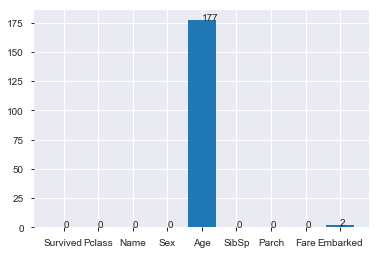

In [6]:
titanic.get_missing_columns()
titanic.plot_missing_data()

For each of 'Age' and 'Embarked': which are MCAR, MAR, or MNAR?
 * MCAR - Missing Completely at Random
    * When the probability of missing data on a variable is unrelated to any other measured variable and is unrelated to the variable with missing values itself.
         * Little's MCAR Test (abbreviated)
            1. Calculate the mean of each column with missing data.
            2. Calculate the mean of each column without missing data.
            3. If a majority of the columns have same/similar means, then it is LIKELY the data is MCAR.
         * We will perform a t-test on mean survival ('Survived') before and after removing the records with missing values.
 * MAR - Missing at Random
    * When the probability of missing data on a variable is related to some other measured variable in the model, but notto the value of the variable with missing values itself.
         * For example, when data are missing on IQ for a given threshold of age (i.e. children don't have an IQ score in the survey).
 * MNAR - Missing not at Random
    * When the missing values on a variable are related to the values of that variable itself, even after controlling for other variables.
         * For example, when data are missing on IQ and only the people with low IQ values have missing observations for this variable.

In [7]:
for col in titanic.missing_columns:
    print(col)
    if titanic.test_for_mcar(col):
        print("\tAssume equal means across samples, therefore MCAR.")
    else:
        print("\tAssume different means across samples, therefore not MCAR")
    print()

Age
	Assume equal means across samples, therefore MCAR.

Embarked
	Assume equal means across samples, therefore MCAR.



Therefore, we will operate under the assumption that both 'Age' and 'Embarked' are MCAR and imputation is a valid method for dealing with their missing values.

Python libraries we could use:
 * [statsmodels.imputation](https://www.statsmodels.org/devel/api.html#imputation)
 * [sklearn.impute](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute)
 * [fancyimpute](https://github.com/iskandr/fancyimpute)
    * [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn-impute-iterativeimputer) == MICE
 * [autoimpute](https://github.com/kearnz/autoimpute)
 * [impyute](https://github.com/eltonlaw/impyute)
 * [datawig](https://github.com/awslabs/datawig)

Relevant forum discussion links:
 * [advice-on-imputing-temperature-data-with-statsmodels-mice](https://datascience.stackexchange.com/questions/52927/advice-on-imputing-temperature-data-with-statsmodels-mice)
 * [how-to-know-which-imputation-is-best-for-impute-my-dataset-from-multiple-imputat](https://stats.stackexchange.com/questions/188288/how-to-know-which-imputation-is-best-for-impute-my-dataset-from-multiple-imputat)

Informational links on topic:
 * [Imputation and Feature Selection](https://amueller.github.io/COMS4995-s18/slides/aml-08-021218-imputation-feature-selection)
 * [Python MICE + XGBoost + Regularized Linear Models](https://www.kaggle.com/mizioan/python-mice-xgboost-regularized-linear-models)
 * [Dealing With Missing Data In Python](https://s3.amazonaws.com/assets.datacamp.com/production/course_17404/slides/chapter4.pdf)
 * [Handling Missing Values in Machine Learning: Part 1](https://archive.is/6Izzd)
 * [Handling Missing Values in Machine Learning: Part 2](http://archive.is/zY1dd)
 * [Imputing missing values with variants of IterativeImputer](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py)

Before we start estimating imputed values and scoring them, we should encode our categorical variables.

In [8]:
titanic.encode_labels('Embarked')
titanic.encode_labels('Sex')
titanic.data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_Code,Sex_Code
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2,1


Next, we're going to extract the passenger's title from their name and encode the resulting column
.

In [9]:
titanic.extract_title()
titanic.encode_labels('Title')
titanic.data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_Code,Sex_Code,Title,Title_Code
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,1,Mr,11
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,0,Mrs,12
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2,0,Miss,8
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,12
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2,1,Mr,11


Now, we will iterate over a handful of estimators for imputation strategies and score the results of each.

In [10]:
columns = titanic.data.select_dtypes('number').columns.tolist()

scorers = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
simple_strats = ['mean', 'median']

estimators = [
    BayesianRidge(), 
    DecisionTreeRegressor(max_features='sqrt'), 
    ExtraTreesRegressor(n_estimators=10), 
    KNeighborsRegressor(n_neighbors=15)
]

for scorer in scorers:
    try:
        results = score_impute_strategies(
            data=titanic.data,
            imp_target='Age',
            columns=columns,
            scorer=scorer,
            n_splits=20,
            max_iter=20,
            simple_strats=simple_strats,
            estimators=estimators
        )
        print(scorer)
        print(results.mean())
        print()
    except ValueError:
        pass

r2
Original          Full Data                0.359597
SimpleImputer     mean                     0.371149
                  median                   0.359278
IterativeImputer  BayesianRidge            0.352831
                  DecisionTreeRegressor    0.374572
                  ExtraTreesRegressor      0.379538
                  KNeighborsRegressor      0.360529
dtype: float64

neg_mean_squared_error
Original          Full Data               -0.147175
SimpleImputer     mean                    -0.144647
                  median                  -0.145444
IterativeImputer  BayesianRidge           -0.144462
                  DecisionTreeRegressor   -0.144370
                  ExtraTreesRegressor     -0.145426
                  KNeighborsRegressor     -0.145082
dtype: float64

neg_mean_absolute_error
Original          Full Data               -0.303079
SimpleImputer     mean                    -0.296553
                  median                  -0.297176
IterativeImputer  BayesianRidge   

Based on these results, we'll go with a DecisionTreeRegressor model to impute values for 'Age'.

In [11]:
columns = titanic.data.select_dtypes('number').columns.tolist()
estimator = DecisionTreeRegressor(max_features='sqrt')
max_iter = 20
titanic.impute_values(
    estimator=estimator,
    column='Age',
    columns=columns,
    max_iter=max_iter
)
titanic.data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_Code,Sex_Code,Title,Title_Code,Age_Impute
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,1,Mr,11,22.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,0,Mrs,12,38.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2,0,Miss,8,26.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,12,35.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2,1,Mr,11,35.0


Next, we need to find a valid strategy for imputing missing values in the 'Embarked' column.

In [12]:
columns = titanic.data.select_dtypes('number').columns.tolist()
columns.remove('Age_Impute')
columns.remove('Age')

simple_strats = ['most_frequent']
estimators = [
    LogisticRegression(multi_class='auto'), 
    DecisionTreeClassifier(), 
    ExtraTreesClassifier(n_estimators=10), 
    KNeighborsClassifier(n_neighbors=15)
]
scorers = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

for scorer in scorers:
    try:
        results = score_impute_strategies(
            data=titanic.data,
            imp_target='Embarked_Code',
            columns=columns,
            scorer=scorer,
            n_splits=20,
            max_iter=20,
            simple_strats=simple_strats,
            estimators=estimators
        )
        print(scorer)
        print(results.mean())
        print()
    except ValueError:
        pass

accuracy
Original          Full Data                 0.792323
SimpleImputer     most_frequent             0.791061
IterativeImputer  LogisticRegression        0.791086
                  DecisionTreeClassifier    0.795631
                  ExtraTreesClassifier      0.789848
                  KNeighborsClassifier      0.794899
dtype: float64

roc_auc
Original          Full Data                 0.848347
SimpleImputer     most_frequent             0.843061
IterativeImputer  LogisticRegression        0.844388
                  DecisionTreeClassifier    0.846897
                  ExtraTreesClassifier      0.840738
                  KNeighborsClassifier      0.835699
dtype: float64

f1
Original          Full Data                 0.707739
SimpleImputer     most_frequent             0.717586
IterativeImputer  LogisticRegression        0.715311
                  DecisionTreeClassifier    0.717302
                  ExtraTreesClassifier      0.712851
                  KNeighborsClassifier      0.7

Based on these results, we'll go with a LogisticRegression model to impute values for 'Embarked_Code'.

In [13]:
columns = titanic.data.select_dtypes('number').columns.tolist()
columns.remove('Age_Impute')
columns.remove('Age')
estimator = LogisticRegression(multi_class='auto')
max_iter = 20
titanic.impute_values(
    estimator=estimator,
    column='Embarked_Code',
    columns=columns,
    max_iter=max_iter
)
titanic.data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_Code,Sex_Code,Title,Title_Code,Age_Impute,Embarked_Code_Impute
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,1,Mr,11,22.0,2.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,0,Mrs,12,38.0,0.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2,0,Miss,8,26.0,2.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,12,35.0,2.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,2,1,Mr,11,35.0,2.0


In [14]:
titanic.decode_dict

{'Embarked': {0: 'C', 1: 'Q', 2: 'S', 3: 'nan'},
 'Sex': {0: 'female', 1: 'male'},
 'Title': {0: 'Capt',
  1: 'Col',
  2: 'Don',
  3: 'Dr',
  4: 'Jonkheer',
  5: 'Lady',
  6: 'Major',
  7: 'Master',
  8: 'Miss',
  9: 'Mlle',
  10: 'Mme',
  11: 'Mr',
  12: 'Mrs',
  13: 'Ms',
  14: 'Rev',
  15: 'Sir',
  16: 'the Countess'}}

## 3. Review descriptive statistics and make note of special values.
 * Special values may lead to new questions related to target variable.

### 3.1 What was the survival rate of women versus men?

,Sex,Survived
0,male,0.188908
1,female,0.742038


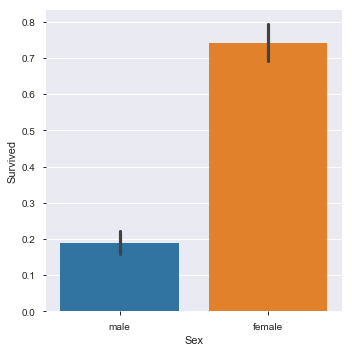

In [15]:
sns.catplot(x="Sex", y="Survived", data=titanic.data, kind='bar', orient='v')
titanic.get_target_correlation('Sex')

The plot above shows women aboard the Titanic had a higher survival rate than men.

### 3.6 What is the population distribution of male vs female?

male      577
female    314
Name: Sex, dtype: int64

male      0.647587
female    0.352413
Name: Sex, dtype: float64

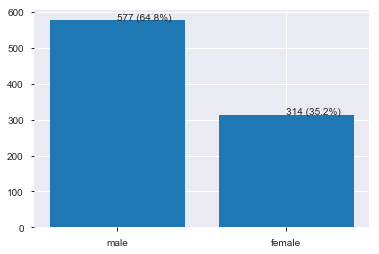

In [16]:
titanic.get_value_counts('Sex')
titanic.get_value_counts('Sex', normalize=True)
titanic.plot_value_counts('Sex')

### 3.2 What was the survival rate of children versus adults?

,Child,Survived
0,0,0.361183
1,1,0.539823


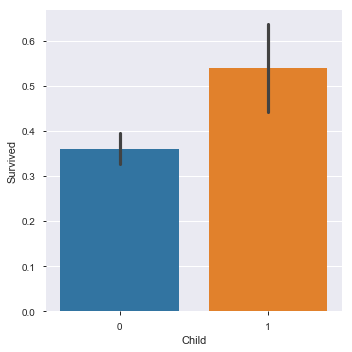

In [17]:
titanic.data['Child'] = 0
titanic.data.loc[titanic.data['Age']<18, 'Child'] = 1
sns.catplot(x="Child", y="Survived", data=titanic.data, kind='bar', orient='v')
titanic.get_target_correlation('Child')

There doesn't appear to be as much of a disparity here as we saw previously with survival rates of men and women. A child's chance of surviving (regardless of sex) is no better than flipping a coin.

### 3.7 What is the population distribution of children and adults?

0    778
1    113
Name: Child, dtype: int64

0    0.873176
1    0.126824
Name: Child, dtype: float64

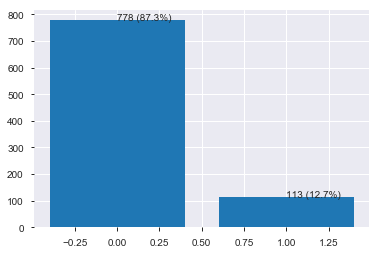

In [18]:
titanic.get_value_counts('Child')
titanic.get_value_counts('Child', normalize=True)
titanic.plot_value_counts('Child')

### 3.5 What was surival rate of sex encoded with a child flag?

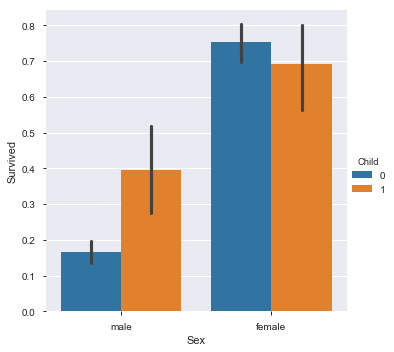

In [19]:
sns.catplot(x="Sex", y="Survived", hue="Child",data=titanic.data, kind='bar', orient='v')

The plot above shows that, despite low survival rate among men, male children enjoyed a marginally higher chance of survival. As we already observed in the previous plot, women, in general, had a much higher survival rate.

Therefore, women, regardless of their age had a higher chance of survival and male adults rarely made it out alive whereas male children had chances less favorable than a coin flip.

### 3.3 Did passenger socio-economic status play a role in survival?

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


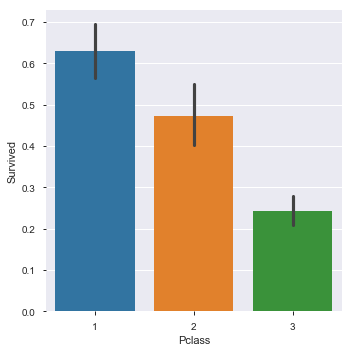

In [20]:
sns.catplot(x="Pclass", y="Survived",data=titanic.data, kind='bar', orient='v')
titanic.get_target_correlation('Pclass')

This plot shows that the higher the class of the passenger, the greater the likelihood of survival.

### 3.4 How does age affect a passengers survival?
 * What if age is compounded with sex?
 * Or with class?

First, we'll look at the distribution of Age (imputed).

###### * Bins are calculated using the [Freedman-Diaconis rule](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule).
###### * Outliers are calculated using [Tukey's fences](https://en.wikipedia.org/wiki/Outlier#Tukey's_fences).

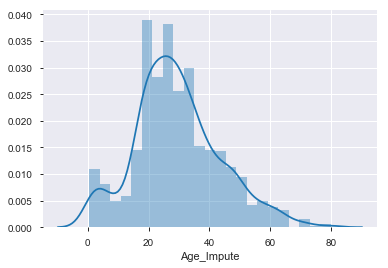

In [21]:
sns.distplot(titanic.data['Age_Impute'])

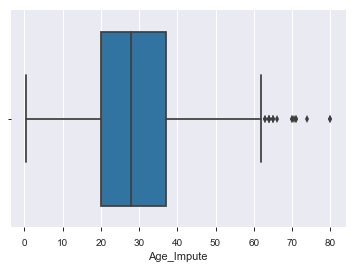

In [22]:
sns.boxplot(titanic.data['Age_Impute'])

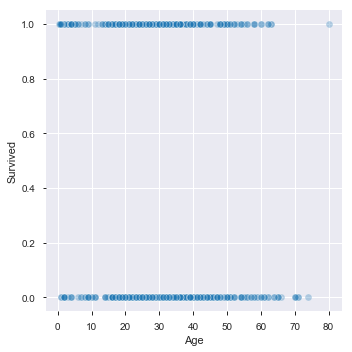

In [23]:
sns.relplot(x='Age', y='Survived', data=titanic.data, alpha=0.3)

There doesn't appear to be any relationship between Age and Survived. However, because there is high variability in this feature, we will include it in the model with the expectation that a hidden relationship will be identified by the model.